# EEG Signal Processing Pipeline
This notebook demonstrates a pipeline to process EEG signals from an EDF file, including preprocessing, applying DMD, and clustering.

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import pyedflib
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pyedflib'

## Step 1: Read EDF File
Load the EEG signal from an EDF file with a sampling frequency of 512 Hz.

In [ ]:
# Load EEG signal from EDF file
edf_file = 'by captain borat/raw/EEG_0_per_hour_2024-03-20 17_12_18.edf'  # Replace with your EDF file path
edf_reader = pyedflib.EdfReader(edf_file)
signal = edf_reader.readSignal(0)  # Read the first channel
fs = 512  # Sampling frequency
edf_reader.close()

## Step 2: Local Interpolation
Interpolate locally for values exceeding 3x the standard deviation within each sliding window.

In [ ]:
# Interpolate locally for outliers within sliding windows
window_size = 30 * fs  # 30 seconds
step_size = 10 * fs  # 10 seconds
corrected_signal = signal.copy()

for start in range(0, len(signal) - window_size + 1, step_size):
    end = start + window_size
    window = corrected_signal[start:end]
    local_threshold = 3 * np.std(window)
    local_outliers = np.abs(window) > local_threshold

    if np.any(~local_outliers) and np.any(local_outliers):
        corrected_signal[start:end][local_outliers] = np.interp(
            np.flatnonzero(local_outliers),
            np.flatnonzero(~local_outliers),
            window[~local_outliers]
        )
    elif np.all(local_outliers):
        # If all points in the window are outliers, use detrending as a fallback
        print(f"Warning: All points identified as outliers in window {start}-{end}. Using detrending instead.")
        corrected_signal[start:end] = detrend(window)

## Step 3: Sliding Window and Standardization
Create sliding windows of 30 seconds and standardize the signal.

In [ ]:
# Create sliding windows and standardize
window_size = 30 * fs  # 30 seconds
step_size = 10 * fs  # 10 seconds
windows = [signal[i:i + window_size] for i in range(0, len(signal) - window_size + 1, step_size)]
scaler = StandardScaler()
standardized_windows = [scaler.fit_transform(w.reshape(-1, 1)).flatten() for w in windows]

## Step 4: Apply DMD
Apply Dynamic Mode Decomposition (DMD) to extract 5 modes and their real and imaginary values.

In [ ]:
# Apply DMD to extract 5 modes
from pydmd import DMD

dmd_modes = []
for w in standardized_windows:
    # Reshape the 1D array into a 2D matrix (required by DMD)
    # Using a shape that divides the window evenly
    # Using 2 rows as a simple approach, but you might adjust based on your needs
    n = len(w)
    w_reshaped = w.reshape(2, n//2)
    
    dmd = DMD(svd_rank=5)
    dmd.fit(w_reshaped)
    # Extract the DMD modes
    modes = dmd.modes.flatten()
    dmd_modes.append(modes)

## Step 5: Clustering
Apply multiple clustering algorithms and calculate metrics to choose the best algorithm and number of clusters.

In [ ]:
# Clustering and evaluation
flattened_modes = [np.hstack([np.real(m), np.imag(m)]) for m in dmd_modes]
metrics = {}

# KMeans
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(flattened_modes)
    silhouette = silhouette_score(flattened_modes, labels)
    db_score = davies_bouldin_score(flattened_modes, labels)
    metrics[f'KMeans_{n_clusters}'] = (silhouette, db_score)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(flattened_modes)
silhouette = silhouette_score(flattened_modes, labels) if len(set(labels)) > 1 else -1
db_score = davies_bouldin_score(flattened_modes, labels) if len(set(labels)) > 1 else -1
metrics['DBSCAN'] = (silhouette, db_score)

# Agglomerative Clustering
for n_clusters in range(2, 10):
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agglo.fit_predict(flattened_modes)
    silhouette = silhouette_score(flattened_modes, labels)
    db_score = davies_bouldin_score(flattened_modes, labels)
    metrics[f'Agglomerative_{n_clusters}'] = (silhouette, db_score)

## Step 6: Plot Metrics
Visualize the metrics to determine the best clustering algorithm and number of clusters.

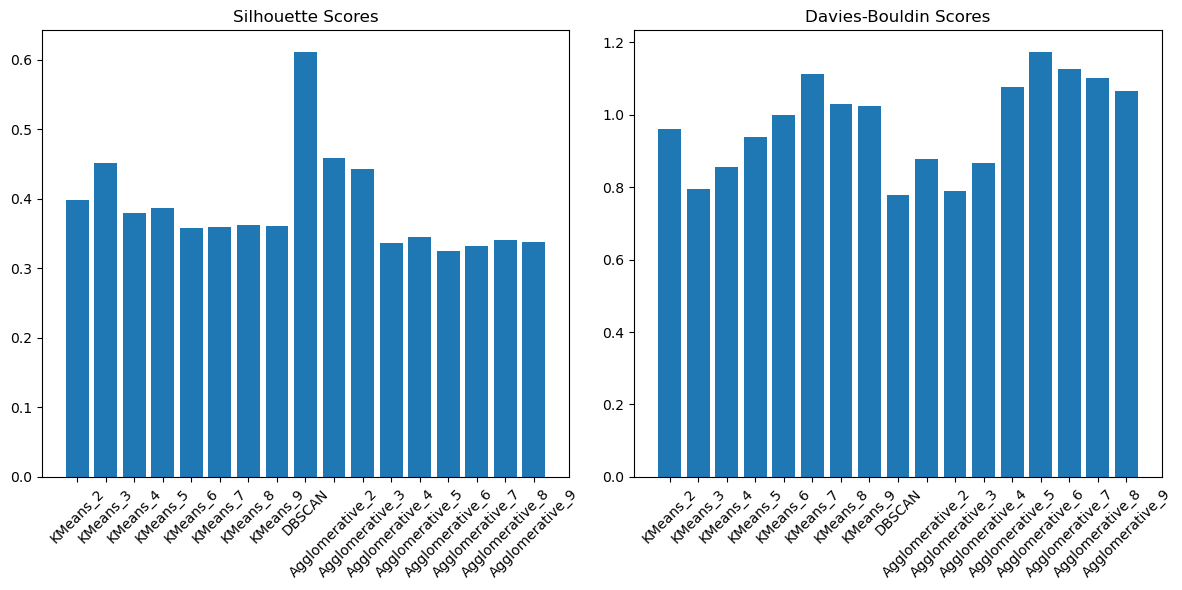

In [ ]:
# Plot clustering metrics
silhouettes = {k: v[0] for k, v in metrics.items()}
db_scores = {k: v[1] for k, v in metrics.items()}

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(silhouettes.keys(), silhouettes.values())
plt.xticks(rotation=45)
plt.title('Silhouette Scores')

plt.subplot(1, 2, 2)
plt.bar(db_scores.keys(), db_scores.values())
plt.xticks(rotation=45)
plt.title('Davies-Bouldin Scores')

plt.tight_layout()
plt.show()

## Step 7: Cluster Windows Using Algorithm X
Cluster the windows using a specific algorithm (e.g., KMeans) and a specific number of clusters.

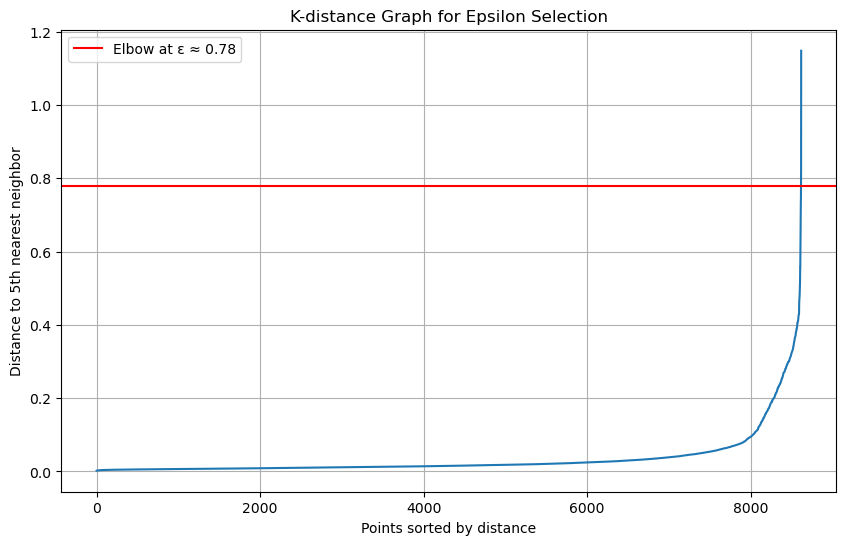

Best parameters: eps=0.389, min_samples=5
Number of clusters: 2
Noise percentage: 0.21%
Silhouette score: 0.565


In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Apply DBSCAN with parameter tuning
import matplotlib.pyplot as plt

# Convert the flattened modes to a numpy array for better handling
X = np.array(flattened_modes)

# Find optimal epsilon parameter by using distance to k-nearest neighbors

# Determine optimal epsilon using k-distance graph
k = 5  # number of neighbors to consider
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)
distances, indices = nn.kneighbors(X)

# Sort the distances to the k-th nearest neighbor
distances = np.sort(distances[:, -1])

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.title('K-distance Graph for Epsilon Selection')
plt.grid(True)

# Add a horizontal line at the elbow point for clearer visualization
# You can adjust this value based on the visual inspection of the plot
elbow_index = np.argmax(np.diff(np.diff(distances)))
elbow_value = distances[elbow_index]
plt.axhline(y=elbow_value, color='r', linestyle='-', label=f'Elbow at ε ≈ {elbow_value:.2f}')
plt.legend()
plt.show()

# Try different epsilon values around the elbow point and min_samples combinations
eps_range = np.linspace(elbow_value * 0.5, elbow_value * 2, 5)
min_samples_range = [3, 5, 10, 15, 20]

results = {}

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Count number of clusters (excluding noise points labeled as -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # Calculate percentage of noise points
        noise_percentage = np.sum(labels == -1) / len(labels) * 100
        
        # Calculate silhouette score if there's more than one cluster
        if n_clusters > 1 and np.sum(labels != -1) > n_clusters:
            try:
                sil_score = silhouette_score(X[labels != -1], labels[labels != -1])
            except:
                sil_score = -1
        else:
            sil_score = -1
            
        results[(eps, min_samples)] = (n_clusters, noise_percentage, sil_score)

# Find the combination with best silhouette score that has reasonable noise percentage
valid_results = {k: v for k, v in results.items() if v[0] > 1 and v[2] > 0}

if valid_results:
    # Sort by silhouette score (descending) and then by noise percentage (ascending)
    best_params = sorted(valid_results.items(), key=lambda x: (-x[1][2], x[1][1]))[0]
    best_eps, best_min_samples = best_params[0]
    best_n_clusters, best_noise_pct, best_sil = best_params[1]
    
    print(f"Best parameters: eps={best_eps:.3f}, min_samples={best_min_samples}")
    print(f"Number of clusters: {best_n_clusters}")
    print(f"Noise percentage: {best_noise_pct:.2f}%")
    print(f"Silhouette score: {best_sil:.3f}")
else:
    # If no valid results, use the parameters with lowest noise percentage
    best_params = min(results.items(), key=lambda x: (-(x[1][0] > 0), x[1][1]))
    best_eps, best_min_samples = best_params[0]
    print(f"No valid clustering found. Using eps={best_eps:.3f}, min_samples={best_min_samples}")

# Apply DBSCAN with the best parameters
best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_labels = best_dbscan.fit_predict(X)

/home/yahia/notebooks/.conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Noise: 18 points (0.2%)
Cluster 0: 8568 points (99.4%)
Cluster 1: 35 points (0.4%)


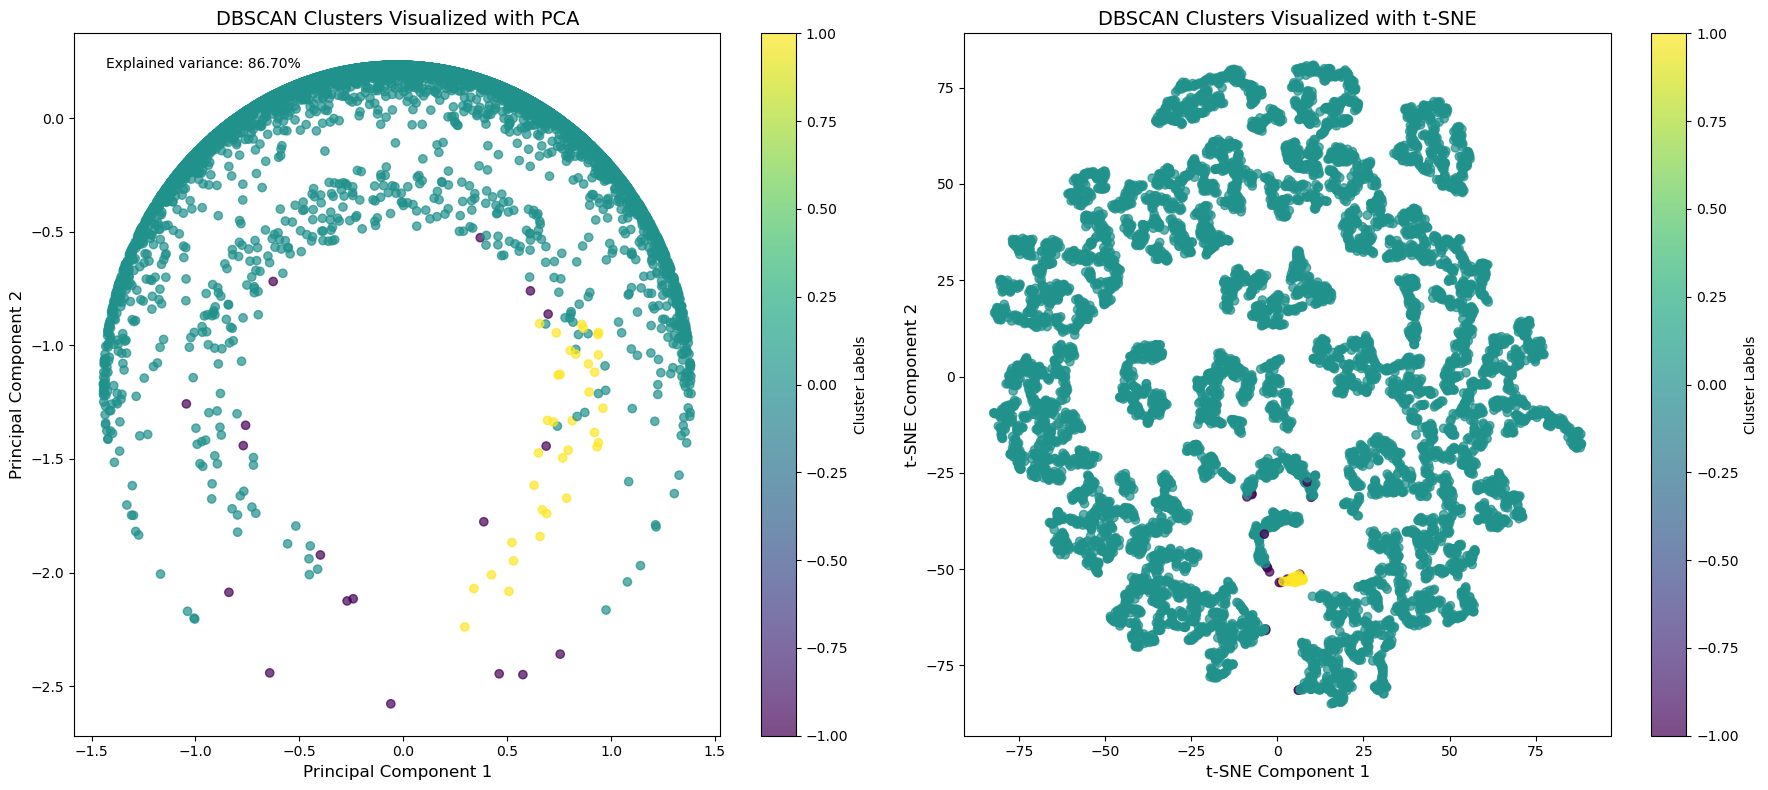

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

# Convert flattened_modes to numpy array if it's not already
X = np.array(flattened_modes)

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
tsne_result = tsne.fit_transform(X)

# Create a figure with two subplots
plt.figure(figsize=(18, 8))

# Plot PCA results
plt.subplot(1, 2, 1)
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=best_labels, cmap='viridis', alpha=0.7)
plt.title('DBSCAN Clusters Visualized with PCA', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Add a colorbar legend
legend1 = plt.colorbar(scatter)
legend1.set_label('Cluster Labels')

# Calculate and display explained variance
explained_variance = pca.explained_variance_ratio_
plt.annotate(f'Explained variance: {sum(explained_variance):.2%}', 
             xy=(0.05, 0.95), xycoords='axes fraction')

# Plot t-SNE results
plt.subplot(1, 2, 2)
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=best_labels, cmap='viridis', alpha=0.7)
plt.title('DBSCAN Clusters Visualized with t-SNE', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)

# Add a colorbar legend
legend2 = plt.colorbar(scatter)
legend2.set_label('Cluster Labels')

# Count points in each cluster
unique_labels = np.unique(best_labels)
for label in unique_labels:
    if label == -1:
        label_name = 'Noise'
    else:
        label_name = f'Cluster {label}'
    count = np.sum(best_labels == label)
    percent = 100 * count / len(best_labels)
    print(f"{label_name}: {count} points ({percent:.1f}%)")

plt.tight_layout()
plt.show()

/home/yahia/notebooks/.conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Cluster 0: 2499 points (29.0%)
Cluster 1: 477 points (5.5%)
Cluster 2: 2399 points (27.8%)
Cluster 3: 190 points (2.2%)
Cluster 4: 400 points (4.6%)
Cluster 5: 1257 points (14.6%)
Cluster 6: 1399 points (16.2%)


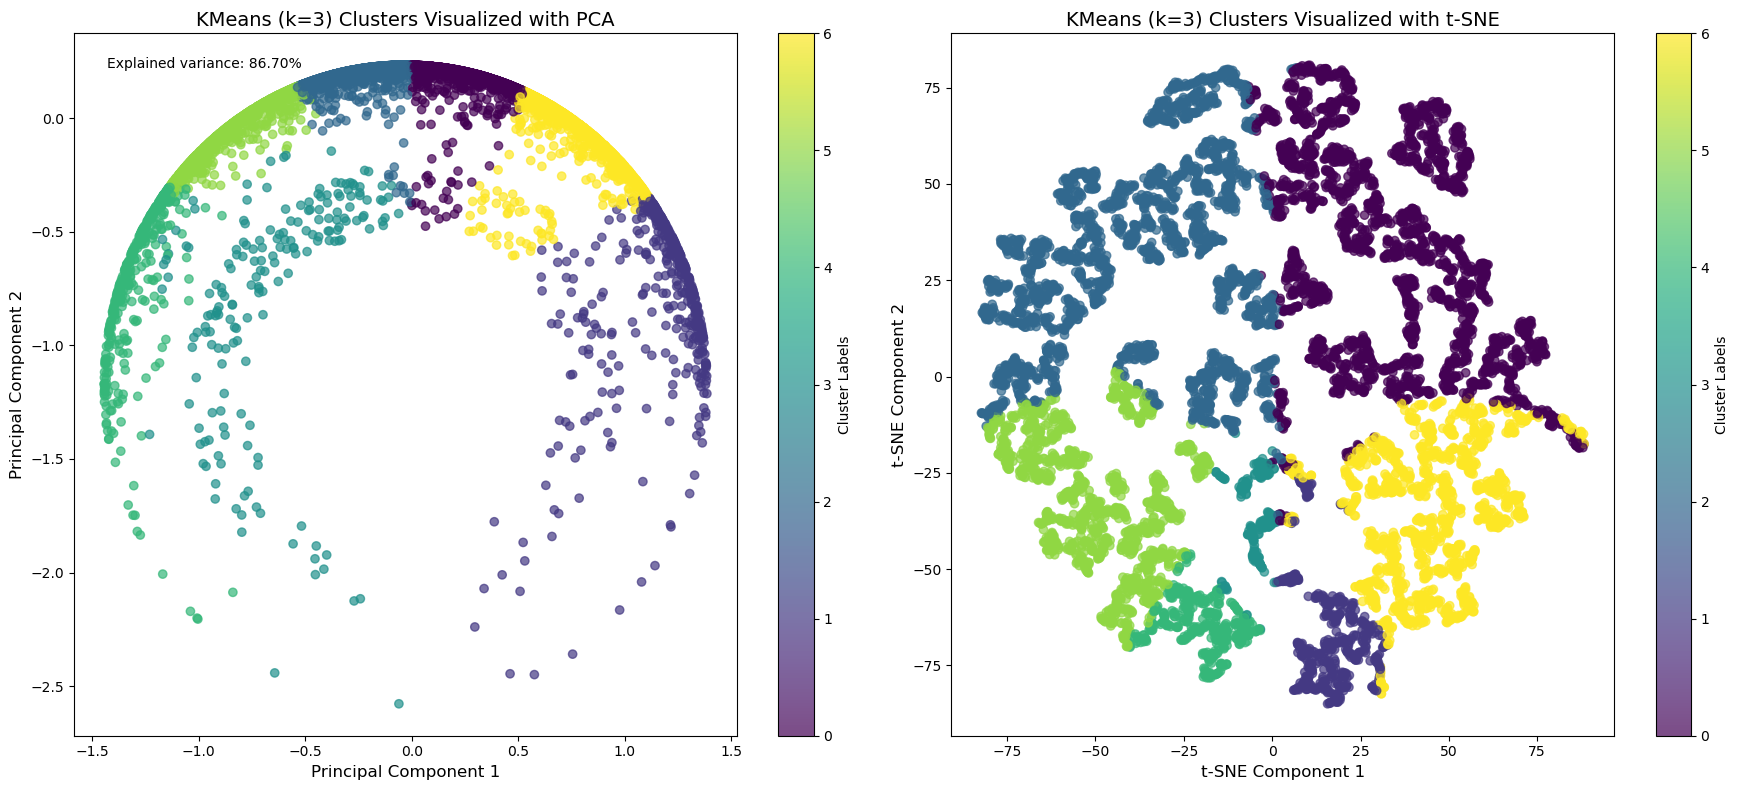

In [ ]:
from sklearn.cluster import KMeans

# Apply KMeans with 3 clusters based on metrics analysis

# Apply KMeans with 3 clusters (which had the best silhouette score in metrics)
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans_labels = kmeans.fit_predict(flattened_modes)

# Convert flattened_modes to numpy array for easier handling
X = np.array(flattened_modes)

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
tsne_result = tsne.fit_transform(X)

# Create a figure with two subplots
plt.figure(figsize=(18, 8))

# Plot PCA results
plt.subplot(1, 2, 1)
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title('KMeans (k=3) Clusters Visualized with PCA', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Add a colorbar legend
legend1 = plt.colorbar(scatter)
legend1.set_label('Cluster Labels')

# Calculate and display explained variance
explained_variance = pca.explained_variance_ratio_
plt.annotate(f'Explained variance: {sum(explained_variance):.2%}', 
             xy=(0.05, 0.95), xycoords='axes fraction')

# Plot t-SNE results
plt.subplot(1, 2, 2)
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title('KMeans (k=3) Clusters Visualized with t-SNE', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)

# Add a colorbar legend
legend2 = plt.colorbar(scatter)
legend2.set_label('Cluster Labels')

# Count points in each cluster
unique_labels = np.unique(kmeans_labels)
for label in unique_labels:
    count = np.sum(kmeans_labels == label)
    percent = 100 * count / len(kmeans_labels)
    print(f"Cluster {label}: {count} points ({percent:.1f}%)")

plt.tight_layout()
plt.show()

/home/yahia/notebooks/.conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Cluster 0: 432 points (5.0%)
Cluster 1: 1035 points (12.0%)
Cluster 2: 899 points (10.4%)
Cluster 3: 2576 points (29.9%)
Cluster 4: 1118 points (13.0%)
Cluster 5: 2561 points (29.7%)


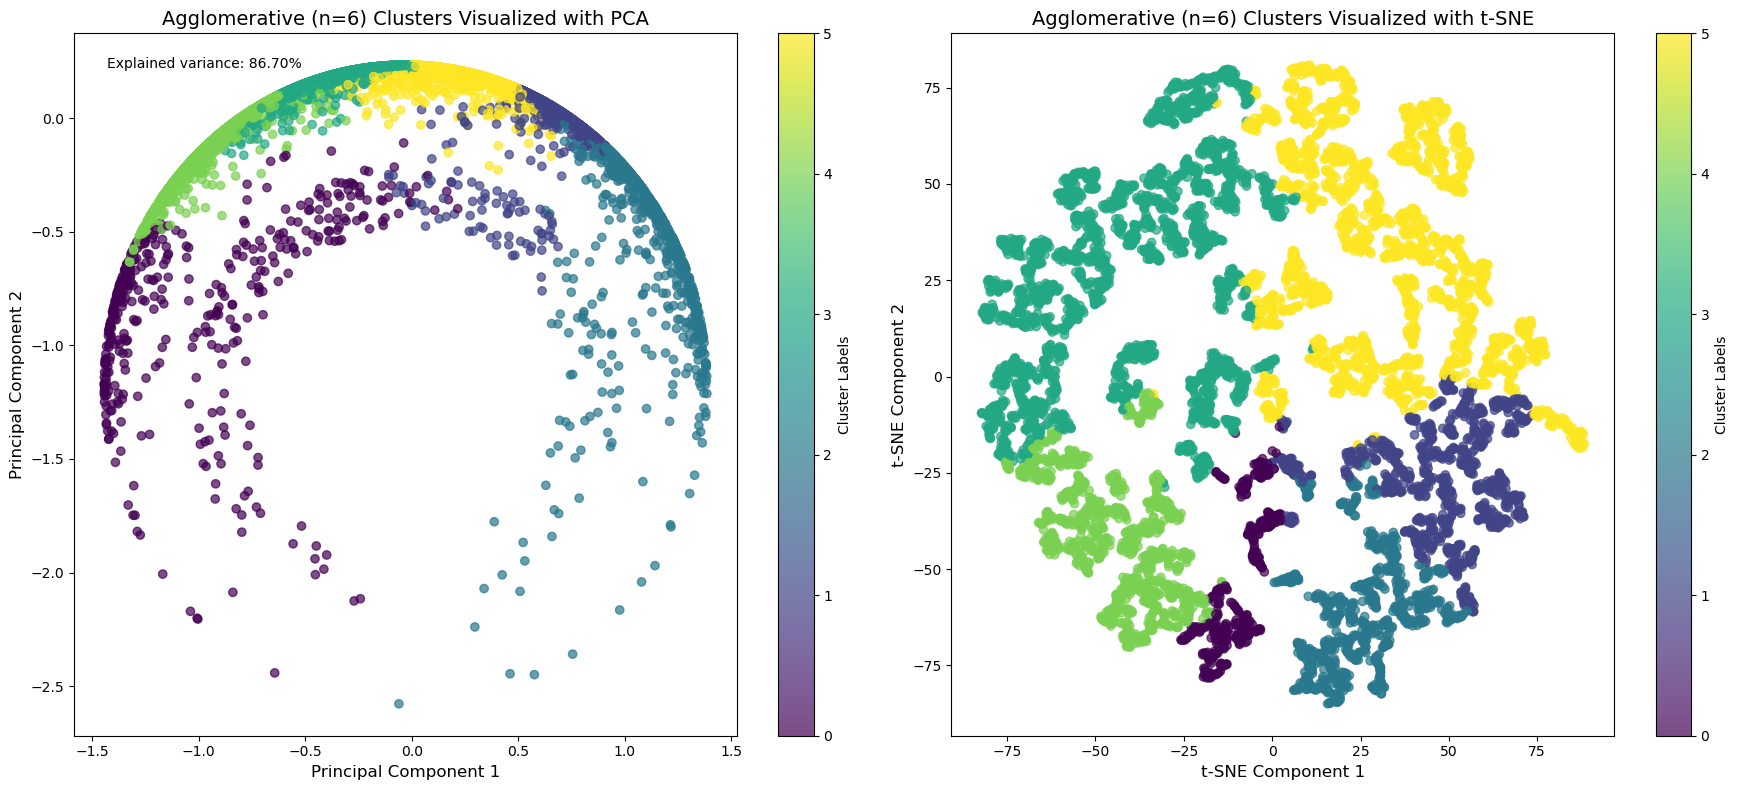

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering with 6 clusters (based on metrics analysis)
agglo = AgglomerativeClustering(n_clusters=6)
agglo_labels = agglo.fit_predict(flattened_modes)

# Convert flattened_modes to numpy array for easier handling
X = np.array(flattened_modes)

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
tsne_result = tsne.fit_transform(X)

# Create a figure with two subplots
plt.figure(figsize=(18, 8))

# Plot PCA results
plt.subplot(1, 2, 1)
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=agglo_labels, cmap='viridis', alpha=0.7)
plt.title('Agglomerative (n=6) Clusters Visualized with PCA', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Add a colorbar legend
legend1 = plt.colorbar(scatter)
legend1.set_label('Cluster Labels')

# Calculate and display explained variance
explained_variance = pca.explained_variance_ratio_
plt.annotate(f'Explained variance: {sum(explained_variance):.2%}', 
             xy=(0.05, 0.95), xycoords='axes fraction')

# Plot t-SNE results
plt.subplot(1, 2, 2)
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=agglo_labels, cmap='viridis', alpha=0.7)
plt.title('Agglomerative (n=6) Clusters Visualized with t-SNE', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)

# Add a colorbar legend
legend2 = plt.colorbar(scatter)
legend2.set_label('Cluster Labels')

# Count points in each cluster
unique_labels = np.unique(agglo_labels)
for label in unique_labels:
    count = np.sum(agglo_labels == label)
    percent = 100 * count / len(agglo_labels)
    print(f"Cluster {label}: {count} points ({percent:.1f}%)")

plt.tight_layout()
plt.show()

OPTICS found 1 clusters
Cannot calculate silhouette score with these clustering results


/home/yahia/notebooks/.conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Cluster 0: 8621 points (100.0%)


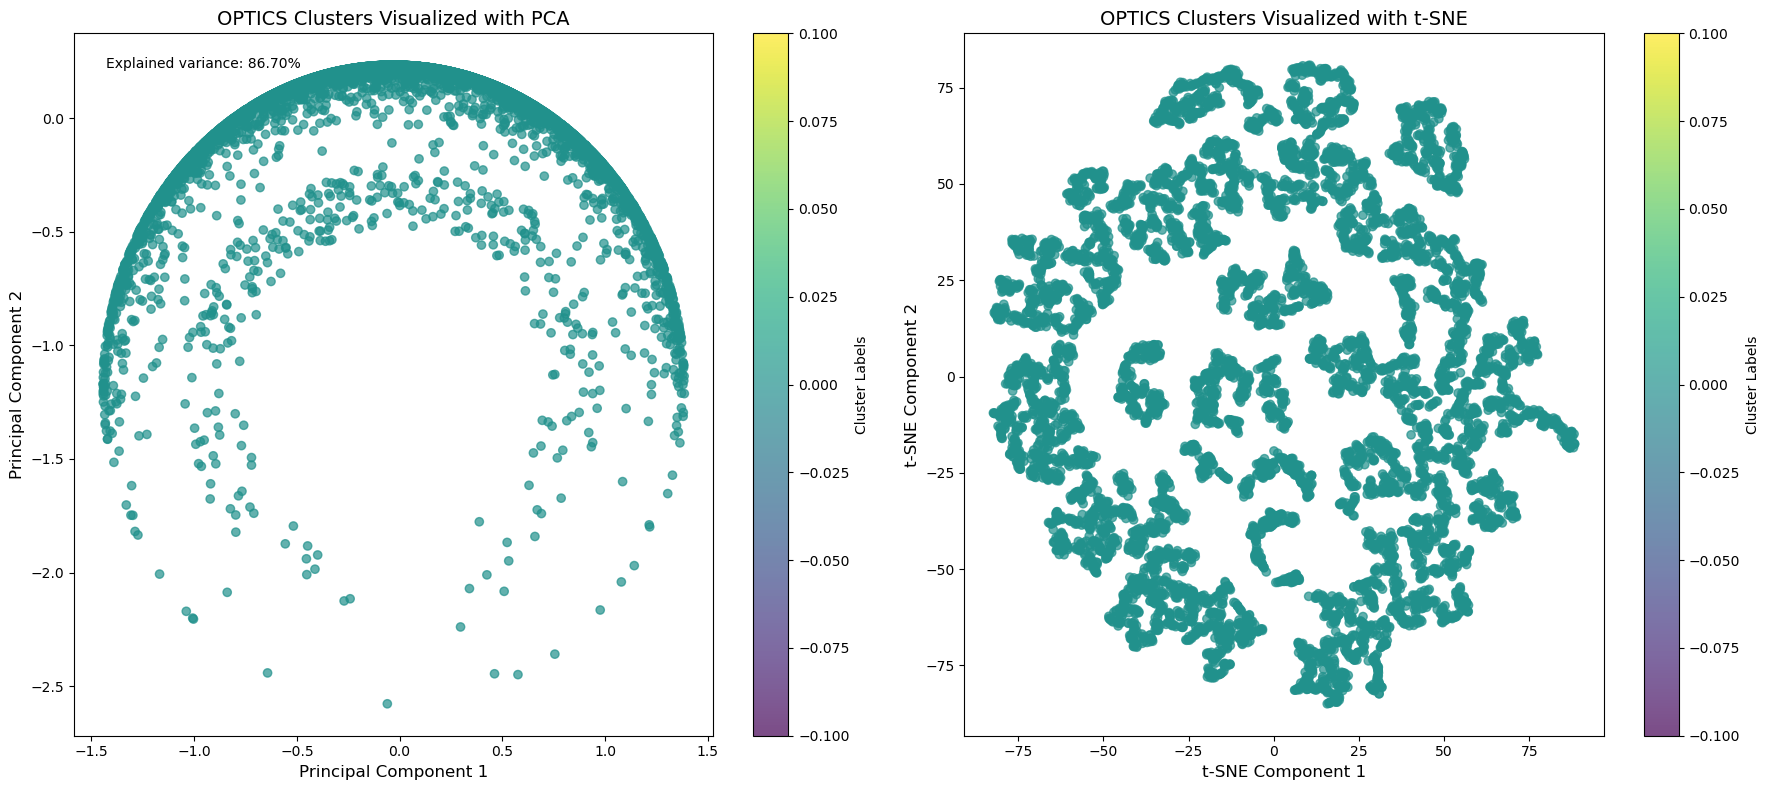

In [ ]:
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

# Convert flattened_modes to numpy array for easier handling
X = np.array(flattened_modes)

# Apply OPTICS clustering
optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
optics_labels = optics.fit_predict(X)

# Find the number of clusters (excluding noise points labeled as -1)
n_clusters = len(set(optics_labels)) - (1 if -1 in optics_labels else 0)
print(f"OPTICS found {n_clusters} clusters")

# If OPTICS found only noise points, let's try with different parameters
if n_clusters == 0:
    optics = OPTICS(min_samples=5, xi=0.1, min_cluster_size=0.03)
    optics_labels = optics.fit_predict(X)
    n_clusters = len(set(optics_labels)) - (1 if -1 in optics_labels else 0)
    print(f"OPTICS with adjusted parameters found {n_clusters} clusters")

# Calculate silhouette score if there's more than one cluster and not all points are noise
if n_clusters > 1 and np.sum(optics_labels != -1) > n_clusters:
    sil_score = silhouette_score(X[optics_labels != -1], optics_labels[optics_labels != -1])
    print(f"Silhouette score: {sil_score:.3f}")
else:
    print("Cannot calculate silhouette score with these clustering results")

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
tsne_result = tsne.fit_transform(X)

# Create a figure with two subplots
plt.figure(figsize=(18, 8))

# Plot PCA results
plt.subplot(1, 2, 1)
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=optics_labels, cmap='viridis', alpha=0.7)
plt.title('OPTICS Clusters Visualized with PCA', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Add a colorbar legend
legend1 = plt.colorbar(scatter)
legend1.set_label('Cluster Labels')

# Calculate and display explained variance
explained_variance = pca.explained_variance_ratio_
plt.annotate(f'Explained variance: {sum(explained_variance):.2%}', 
             xy=(0.05, 0.95), xycoords='axes fraction')

# Plot t-SNE results
plt.subplot(1, 2, 2)
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=optics_labels, cmap='viridis', alpha=0.7)
plt.title('OPTICS Clusters Visualized with t-SNE', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)

# Add a colorbar legend
legend2 = plt.colorbar(scatter)
legend2.set_label('Cluster Labels')

# Count points in each cluster
unique_labels = np.unique(optics_labels)
for label in unique_labels:
    if label == -1:
        label_name = 'Noise'
    else:
        label_name = f'Cluster {label}'
    count = np.sum(optics_labels == label)
    percent = 100 * count / len(optics_labels)
    print(f"{label_name}: {count} points ({percent:.1f}%)")

plt.tight_layout()
plt.show()

/home/yahia/notebooks/.conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/yahia/notebooks/.conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN found 8 clusters
Noise percentage: 2.04%


/home/yahia/notebooks/.conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_2825414/1867737411.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', n_clusters)
/tmp/ipykernel_2825414/1867737411.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', n_clusters)


Noise: 176 points (2.0%)
Cluster 0: 29 points (0.3%)
Cluster 1: 20 points (0.2%)
Cluster 2: 22 points (0.3%)
Cluster 3: 12 points (0.1%)
Cluster 4: 26 points (0.3%)
Cluster 5: 28 points (0.3%)
Cluster 6: 15 points (0.2%)
Cluster 7: 8293 points (96.2%)
Average cluster membership probability: 0.999
Average probability for Cluster 0: 0.921
Average probability for Cluster 1: 0.960
Average probability for Cluster 2: 0.916
Average probability for Cluster 3: 0.991
Average probability for Cluster 4: 0.955
Average probability for Cluster 5: 0.933
Average probability for Cluster 6: 0.990
Average probability for Cluster 7: 1.000


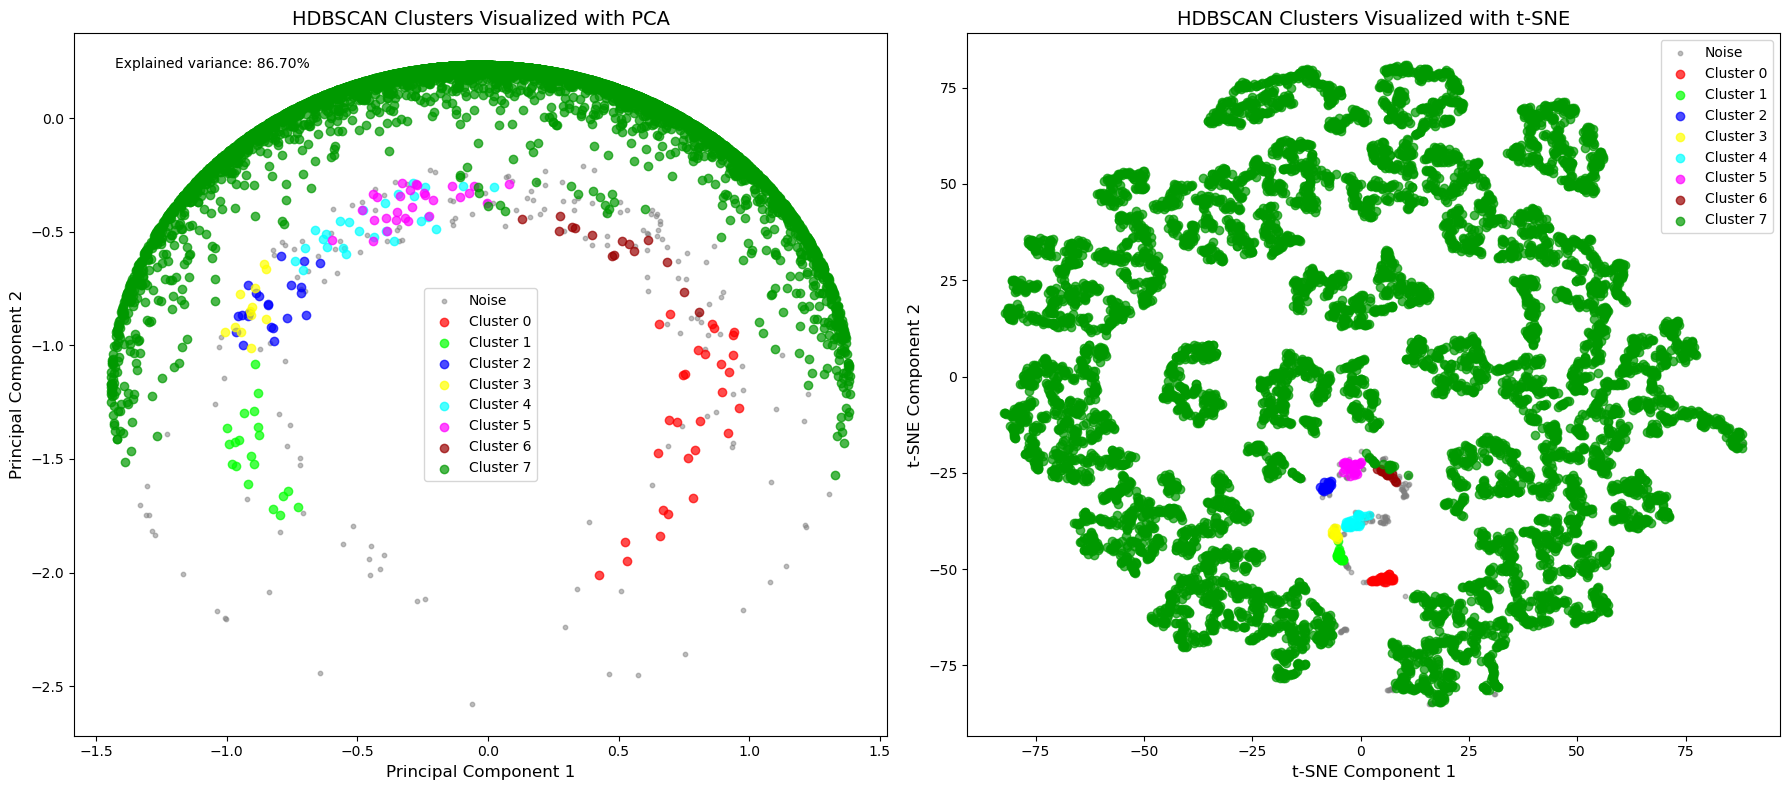

In [ ]:
import hdbscan
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

import matplotlib.pyplot as plt

# Convert flattened_modes to numpy array for easier handling
X = np.array(flattened_modes)

# Apply HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_epsilon=0.3, 
                           prediction_data=True, cluster_selection_method='eom')
hdbscan_labels = clusterer.fit_predict(X)

# Get the number of clusters
n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
print(f"HDBSCAN found {n_clusters} clusters")

# Calculate noise percentage
noise_percent = 100 * np.sum(hdbscan_labels == -1) / len(hdbscan_labels)
print(f"Noise percentage: {noise_percent:.2f}%")

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
tsne_result = tsne.fit_transform(X)

# Create a figure with two subplots
plt.figure(figsize=(18, 8))

# Define a colormap that treats noise points differently
colors = np.array(['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#00ffff', '#ff00ff', '#990000', '#009900'])
cmap = plt.cm.get_cmap('viridis', n_clusters)
noise_color = '#7f7f7f'  # Gray color for noise points

# Plot PCA results
plt.subplot(1, 2, 1)
for i in range(-1, n_clusters):
    mask = (hdbscan_labels == i)
    if i == -1:  # Noise points
        plt.scatter(pca_result[mask, 0], pca_result[mask, 1], c=noise_color, label='Noise', alpha=0.5, s=10)
    else:  # Cluster points
        plt.scatter(pca_result[mask, 0], pca_result[mask, 1], c=[colors[i]], label=f'Cluster {i}', alpha=0.7)

plt.title('HDBSCAN Clusters Visualized with PCA', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()

# Calculate and display explained variance
explained_variance = pca.explained_variance_ratio_
plt.annotate(f'Explained variance: {sum(explained_variance):.2%}', 
             xy=(0.05, 0.95), xycoords='axes fraction')

# Plot t-SNE results
plt.subplot(1, 2, 2)
for i in range(-1, n_clusters):
    mask = (hdbscan_labels == i)
    if i == -1:  # Noise points
        plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1], c=noise_color, label='Noise', alpha=0.5, s=10)
    else:  # Cluster points
        plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1], c=[colors[i]], label=f'Cluster {i}', alpha=0.7)

plt.title('HDBSCAN Clusters Visualized with t-SNE', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend()

# Count points in each cluster
unique_labels = np.unique(hdbscan_labels)
for label in unique_labels:
    if label == -1:
        label_name = 'Noise'
    else:
        label_name = f'Cluster {label}'
    count = np.sum(hdbscan_labels == label)
    percent = 100 * count / len(hdbscan_labels)
    print(f"{label_name}: {count} points ({percent:.1f}%)")

# Print cluster probability metrics
if hasattr(clusterer, 'probabilities_'):
    cluster_probs = clusterer.probabilities_
    cluster_mask = hdbscan_labels != -1
    if np.any(cluster_mask):
        avg_prob = np.mean(cluster_probs[cluster_mask])
        print(f"Average cluster membership probability: {avg_prob:.3f}")
        
        for i in range(n_clusters):
            cluster_i_mask = hdbscan_labels == i
            if np.any(cluster_i_mask):
                avg_cluster_prob = np.mean(cluster_probs[cluster_i_mask])
                print(f"Average probability for Cluster {i}: {avg_cluster_prob:.3f}")

plt.tight_layout()
plt.show()

In [ ]:
from scipy import signal as spsignal

def visualize_clusters(start_time, end_time, clustering_algorithm=1):
    """
    Visualize clusters along with the original signal and multitaper spectrogram.
    
    Parameters:
    -----------
    start_time : float or int
        Start time in seconds
    end_time : float or int
        End time in seconds
    clustering_algorithm : int (1-5)
        Which clustering algorithm to use:
        1: DBSCAN
        2: KMeans
        3: Agglomerative
        4: OPTICS
        5: HDBSCAN
    """
    # Check inputs
    if end_time <= start_time:
        print("End time must be greater than start time")
        return
    
    # Convert time to indices
    start_idx = int(start_time * fs)
    end_idx = int(end_time * fs)
    
    if start_idx < 0 or end_idx > len(signal):
        print("Time range out of bounds")
        return
    
    # Get window indices for this time period
    # windows start at multiples of step_size
    window_start_times = np.arange(0, len(signal) - window_size + 1, step_size) / fs
    window_indices = np.where((window_start_times >= start_time) & 
                             (window_start_times < end_time))[0]
    
    # Select clustering labels based on algorithm choice
    if clustering_algorithm == 1:
        labels = best_labels
        algo_name = "DBSCAN"
    elif clustering_algorithm == 2:
        labels = kmeans_labels
        algo_name = "KMeans"
    elif clustering_algorithm == 3:
        labels = agglo_labels
        algo_name = "Agglomerative"
    elif clustering_algorithm == 4:
        labels = optics_labels
        algo_name = "OPTICS"
    elif clustering_algorithm == 5:
        labels = hdbscan_labels
        algo_name = "HDBSCAN"
    else:
        print("Invalid clustering algorithm. Choose 1-5.")
        return
    
    # Get labels for selected windows
    segment_labels = labels[window_indices]
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    
    # Plot 1: Original signal
    ax1 = plt.subplot2grid((3, 1), (0, 0))
    time = np.arange(start_idx, end_idx) / fs
    ax1.plot(time, signal[start_idx:end_idx])
    ax1.set_title(f'Original EEG Signal ({start_time}s - {end_time}s)')
    ax1.set_ylabel('Amplitude (μV)')
    ax1.grid(True)
    
    # Color bands for different clusters
    unique_labels = np.unique(segment_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    
    # Create colored background for each window showing its cluster
    for i, window_idx in enumerate(window_indices):
        window_start_sample = int(window_idx * step_size)
        window_end_sample = window_start_sample + window_size
        
        # Only show if window is within our visible range
        if window_end_sample >= start_idx and window_start_sample <= end_idx:
            # Adjust bounds to our visible range
            visible_start = max(window_start_sample, start_idx)
            visible_end = min(window_end_sample, end_idx)
            
            # Get corresponding times
            visible_start_time = visible_start / fs
            visible_end_time = visible_end / fs
            
            # Get label for this window
            label = segment_labels[i]
            
            # Skip noise points for density-based clustering
            if label == -1:
                color = 'lightgray'
                alpha = 0.3
            else:
                # Find the index of this label in our unique labels
                label_idx = np.where(unique_labels == label)[0][0]
                color = colors[label_idx]
                alpha = 0.3
            
            # Add colored background
            ax1.axvspan(visible_start_time, visible_end_time, color=color, alpha=alpha)
    
    # Plot 2: Multitaper spectrogram
    ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2)
    
    # Import needed modules for multitaper spectrogram
    
    # Calculate multitaper spectrogram
    segment = signal[start_idx:end_idx]
    fs_spec = fs  # sampling frequency
    window_length = 4 * fs_spec  # 4 second windows
    
    if len(segment) < window_length:
        window_length = len(segment) // 2
        
    noverlap = window_length // 2
    
    # Compute the multitaper spectrogram
    f, t, Sxx = spsignal.spectrogram(
        segment, 
        fs=fs_spec, 
        window=('dpss', 4),
        nperseg=window_length, 
        noverlap=noverlap, 
        scaling='spectrum'
    )
    
    # Plot as dB power
    Sxx_db = 10 * np.log10(Sxx)
    
    # Only display frequencies up to 50 Hz
    mask = f <= 50
    
    # Plot the spectrogram
    pcm = ax2.pcolormesh(t + start_time, f[mask], Sxx_db[mask], cmap='viridis', shading='gouraud')
    ax2.set_ylabel('Frequency (Hz)')
    ax2.set_xlabel('Time (s)')
    ax2.set_title(f'Multitaper Spectrogram with {algo_name} Clustering')
    
    # Add a colorbar
    cbar = fig.colorbar(pcm, ax=ax2)
    cbar.set_label('Power/Frequency (dB/Hz)')
    
    # Create marker lines in spectrogram for cluster transitions
    for i, window_idx in enumerate(window_indices):
        if i > 0 and segment_labels[i] != segment_labels[i-1]:
            # Cluster boundary
            window_time = window_start_times[window_indices[i]]
            if start_time <= window_time <= end_time:
                ax2.axvline(x=window_time, color='red', linestyle='--', alpha=0.7)
    
    # Add legend for clusters
    legend_elements = []
    for label in unique_labels:
        if label == -1:
            legend_elements.append(plt.Line2D([0], [0], color='lightgray', lw=10, label='Noise'))
        else:
            label_idx = np.where(unique_labels == label)[0][0]
            legend_elements.append(plt.Line2D([0], [0], color=colors[label_idx], lw=10, 
                                            label=f'Cluster {label}'))
    
    ax1.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.12, 1))
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"Time range: {start_time}s to {end_time}s")
    print(f"Clustering algorithm: {algo_name}")
    print(f"Windows in this segment: {len(window_indices)}")
    
    # Count cluster occurrences
    for label in unique_labels:
        label_name = f'Cluster {label}' if label != -1 else 'Noise'
        count = np.sum(segment_labels == label)
        percent = 100 * count / len(segment_labels) if len(segment_labels) > 0 else 0
        print(f"{label_name}: {count} windows ({percent:.1f}%)")

In [ ]:
for i in range(1, 6):
    start_time = 1000  # Start at the beginning of the signal
    for j in range(1, 10):
        start_time += 600 * (j-1)
        end_time = start_time + 600
        visualize_clusters(start_time, end_time, clustering_algorithm=i)
# Visualize the first hour with different clustering algorithms
